In [6]:
import os
import requests
import zipfile
import re
import rasterio
import numpy as np
import glob
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import skew, kurtosis
from shapely.geometry import Point
from scipy.stats import mode
from shapely.geometry import Point

In [7]:

def generate_latlon_grid_csv_fast(country_gdf, resolution_km=1, output_csv="grid_points.csv"):
    """
    Efficiently generate a latitude/longitude grid within Algeria and Tunisia
    using vectorized operations (fast version).
    """
    print("📏 Generating grid points (optimized)...")

    # --- 1. Reproject to a metric CRS (UTM 31N for Algeria/Tunisia) ---
    metric_crs = "EPSG:32631"
    countries_proj = country_gdf.to_crs(metric_crs)

    # --- 2. Compute bounding box ---
    minx, miny, maxx, maxy = countries_proj.total_bounds
    spacing = resolution_km * 1000  # meters

    # --- 3. Generate grid coordinates (vectorized) ---
    xs = np.arange(minx, maxx + spacing, spacing)
    ys = np.arange(miny, maxy + spacing, spacing)
    xx, yy = np.meshgrid(xs, ys)
    coords = np.column_stack([xx.ravel(), yy.ravel()])

    print(f"🧮 Created {len(coords):,} total grid points before filtering.")

    # --- 4. Convert all points into a GeoDataFrame (single call) ---
    grid_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coords[:, 0], coords[:, 1]),
        crs=metric_crs
    )

    # --- 5. Use spatial join to keep only points within country polygons (fast) ---
    print("🧭 Filtering points inside polygons (using spatial join)...")
    country_union = countries_proj.dissolve().geometry.iloc[0]
    grid_gdf = grid_gdf[grid_gdf.within(country_union)]

    # --- 6. Reproject to geographic coordinates ---
    grid_gdf = grid_gdf.to_crs("EPSG:4326")  # ✅ FIXED HERE

    # --- 7. Extract lon/lat and save ---
    grid_gdf["longitude"] = grid_gdf.geometry.x
    grid_gdf["latitude"] = grid_gdf.geometry.y
    grid_gdf[["longitude", "latitude"]].to_csv(output_csv, index=False)

    print(f"✅ {len(grid_gdf):,} points inside area (resolution: {resolution_km} km).")
    print(f"💾 Saved grid to: {output_csv}")

    return grid_gdf


 


In [ ]:
shapefile_path = "C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\shapefile\\landcover_algerie_tunisie.shp"
country_gdf = gpd.read_file(shapefile_path)

grid_km = generate_latlon_grid_csv_fast(country_gdf, resolution_km=1, output_csv="points.csv")


📏 Generating grid points (optimized)...
🧮 Created 4,322,237 total grid points before filtering.
🧭 Filtering points inside polygons (using spatial join)...
✅ 2,481,850 points inside area (resolution: 1 km).
💾 Saved grid to: algeria_tunisia_grid3.csv


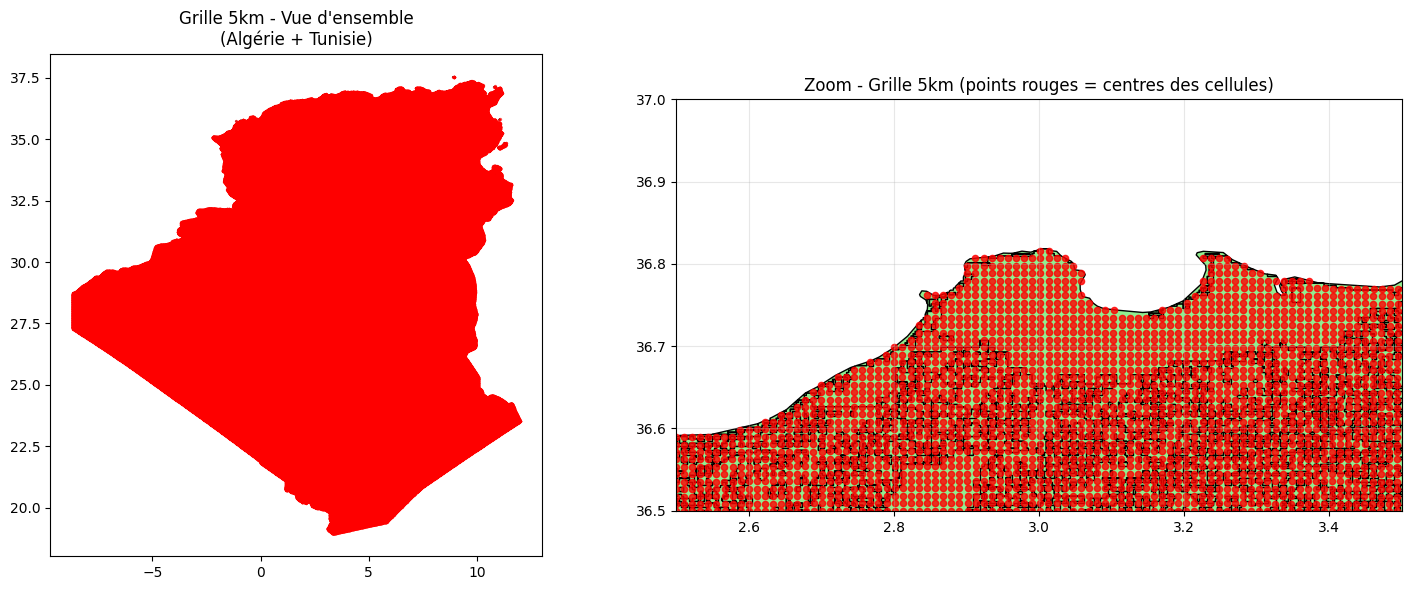

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualiser_grille_5km(country_gdf, grid_points):
    """
    Visualise comment la grille 5km couvre le territoire
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Carte 1: Vue d'ensemble
    country_gdf.plot(ax=ax1, color='lightblue', edgecolor='black')
    grid_points.plot(ax=ax1, color='red', markersize=2, alpha=0.6)
    ax1.set_title("Grille 5km - Vue d'ensemble\n(Algérie + Tunisie)")
    
    # Carte 2: Zoom sur une petite région
    zoom_bounds = [2.5, 36.5, 3.5, 37.0]  # Région d'Alger
    ax2.set_xlim(zoom_bounds[0], zoom_bounds[2])
    ax2.set_ylim(zoom_bounds[1], zoom_bounds[3])
    
    country_gdf.plot(ax=ax2, color='lightgreen', edgecolor='black')
    grid_points.plot(ax=ax2, color='red', markersize=20, alpha=0.8)
    
    # Ajouter la grille visuelle
    ax2.grid(True, alpha=0.3)
    ax2.set_title("Zoom - Grille 5km (points rouges = centres des cellules)")
    
    plt.tight_layout()
    plt.show()

# Visualisez votre grille
visualiser_grille_5km(country_gdf, grid_km)

In [9]:
import pandas as pd

df_points = pd.read_csv("C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\points.csv")
print("apres arrondissement a 3 décimales points")
df_points['latitude'] = df_points['latitude'].round(3)
df_points['longitude'] = df_points['longitude'].round(3)
df_points=df_points[['latitude','longitude']].drop_duplicates()
df_points.to_csv("C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\points.csv", index=False)

df_fires = pd.read_csv("C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\fires.csv")
print("apres arrondissement a 3 décimales fires")
df_fires['latitude'] = df_fires['latitude'].round(3)
df_fires['longitude'] = df_fires['longitude'].round(3)
df_fires.to_csv("C:\\Users\\hp\\Desktop\\TPs\\DataMining\\csv_final\\fires.csv", index=False)


apres arrondissement a 3 décimales points
apres arrondissement a 3 décimales fires


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def afficher_feux_sur_carte(shp_path, csv_path, output_image="carte_feux.png"):
    """
    Affiche les points de feu CSV sur la carte shapefile
    """
    print("🗺️ Chargement des données...")
    
    # 1. Charger le shapefile
    carte = gpd.read_file(shp_path)
    print(f"✅ Shapefile chargé: {len(carte)} polygones")
    
    # 2. Charger les points de feu CSV
    df_feux = pd.read_csv(csv_path)
    print(f"✅ CSV feux chargé: {len(df_feux)} points")
    
    # Vérifier les colonnes
    print(f"📋 Colonnes CSV: {list(df_feux.columns)}")
    
    # 3. Convertir CSV en GeoDataFrame
    # Chercher automatiquement les colonnes lat/lon
    lat_col, lon_col = None, None
    for col in df_feux.columns:
        col_lower = col.lower()
        if 'lat' in col_lower or 'y' in col_lower:
            lat_col = col
        if 'lon' in col_lower or 'x' in col_lower or 'long' in col_lower:
            lon_col = col
    
    if not lat_col or not lon_col:
        print("❌ Colonnes latitude/longitude non trouvées")
        print("   Utilisation des colonnes 0 et 1 par défaut...")
        lat_col, lon_col = df_feux.columns[0], df_feux.columns[1]
    
    print(f"🎯 Colonnes utilisées: {lat_col} (lat), {lon_col} (lon)")
    
    # Créer GeoDataFrame
    gdf_feux = gpd.GeoDataFrame(
        df_feux,
        geometry=gpd.points_from_xy(df_feux[lon_col], df_feux[lat_col]),
        crs="EPSG:4326"  # WGS84
    )
    
    # 4. Assurer le même CRS
    gdf_feux = gdf_feux.to_crs(carte.crs)
    
    # 5. Créer la carte
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Afficher la carte de base
    carte.plot(ax=ax, color="#fb973f", edgecolor="#5eff5b", alpha=0.7, label='Pays')
    
    # Afficher les points de feu
    gdf_feux.plot(ax=ax, color='red', markersize=20, alpha=0.7, 
                  marker='o', label='Points de feu')
    
    # Personnalisation
    plt.title('Distribution des Feux en Algérie et Tunisie', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Statistiques
    stats_text = f"Total feux: {len(gdf_feux)}\nPays: Algérie + Tunisie"
    plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                fontsize=10, verticalalignment='top')
    
    # Sauvegarder
    plt.savefig(output_image, dpi=300, bbox_inches='tight')
    print(f"💾 Carte sauvegardée: {output_image}")
    
    plt.show()
    
    return carte, gdf_feux

# UTILISATION
carte, feux = afficher_feux_sur_carte(
    shp_path=r"C:\Users\hp\Desktop\TPs\DataMining\DATA\shapefile\landcover_algerie_tunisie.shp",
    csv_path="filtered_fire_data.csv",  # Remplacez par votre fichier
    output_image="carte_feux.png"
)

🗺️ Chargement des données...
✅ Shapefile chargé: 438513 polygones
✅ CSV feux chargé: 14216 points
📋 Colonnes CSV: ['latitude', 'longitude']
🎯 Colonnes utilisées: latitude (lat), longitude (lon)


In [2]:
import pandas as pd

df=pd.read_csv("filtered_fire_data.csv")
print(df.columns)
describe=df.describe()
print(describe)

Index(['latitude', 'longitude'], dtype='object')
           latitude     longitude
count  14216.000000  14216.000000
mean      31.679467      6.212258
std        2.851077      2.792512
min       19.603230     -8.118050
25%       30.221690      5.411770
50%       31.363310      6.511675
75%       32.528100      8.045517
max       37.323460     11.110350
